In [1]:
%run Latex_macros.ipynb
%run beautify_plots.py

<IPython.core.display.Latex object>

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import svm, pipeline
from sklearn.preprocessing import PolynomialFeatures

import training_models_helper as tmh
%aimport training_models_helper

tm = tmh.TrainingModelsHelper()

import svm_helper
%aimport svm_helper
svmh = svm_helper.SVM_Helper()

kn = tmh.KNN_Helper()

import transform_helper
%aimport transform_helper

th = transform_helper.Transformation_Helper()

iph = transform_helper.InfluentialPoints_Helper()

import svm_helper
%aimport svm_helper
svmh = svm_helper.SVM_Helper()

import class_helper
%aimport class_helper


# Transformations

We now spend more time on transforming data.

This may be *the most crucial* step in Classical Machine Learning.
This is the art of Feature Engineering
- transforming features
- adding features
all in the service of finding good predictors


We have already seen some rudimentary transformations
- Polynomial transformation of our "curvy" data set
- Numericalization for for Categorical variables in the Titanic problem
- Price level to Percent Price Change for stock return prediction


# Why might we need Synthetic Variables (transformed variables)

- Compatibility
    - non-numeric to number (one-hot)
    - text to categorical

- To squeeze your problem into the model
    - need to make relationships linear to use a Linear model
    
- Because your model may *demand* it
    - Linear Regression demands
        - homoscedastic residuals
        - normality assumption
    - Some models need all features on similar scale
        - KNN distance metric


- To remove an extraneous relationship
    - "lumpy" data
        - clusters of data groups (e.g., sampled at different times) with differences
        - may violate model assumptions (e.g., independent residuals)
        
- To find the "right" relationship
    - may be a ratio/product between two features, or target and feature
        - area vs (length times width)
        - buying power (Price/GDP)
        

# Linearity inducing transformations: Making data fit your model

Many models for Regression and Classification tasks are
based on *linear* relationships between features and target.

One type of transformation creates linearity where it does not
naturally exist in the raw examples.

## Transforming features to induce a linear relationship

We witnessed such on transformation in our Introduction
- Raw examples are not linearly-separable


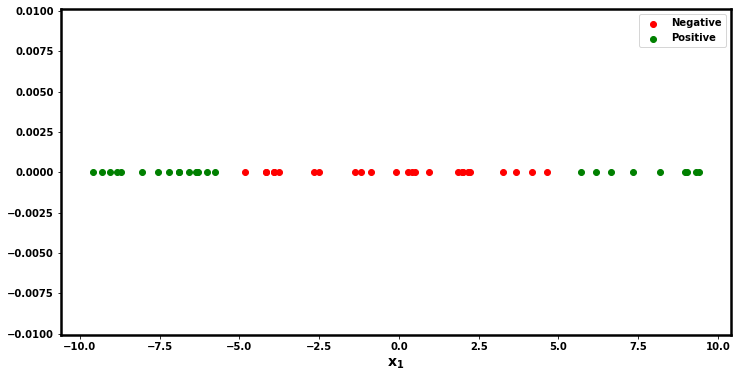

In [4]:
th = transform_helper.Transformation_Helper()
fig_raw, ax_raw, fig_trans, ax_trans = th.LinearSeparate_1d_example(max_val=10, num_examples=50, visible=False)

fig_raw

Transformation that adds a feature makes the examples linearly-separable.

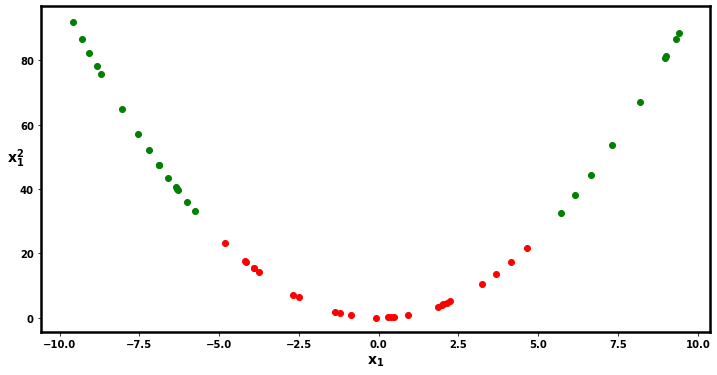

In [5]:
fig_trans

## Transforming targets to induce a linear relationship

We witnessed such a transformation in our discussion of Binary Classification.

Examples for which  Linear Regression on raw target values results in a poor fit

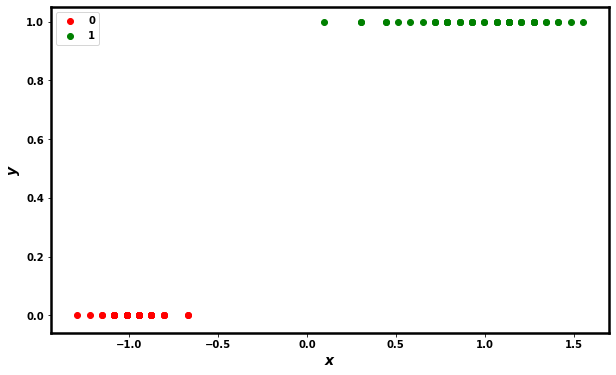

In [6]:
lsh = class_helper.LinearSep_Helper()
X_ls, y_ls = lsh.load_iris()

fig, ax = plt.subplots(figsize=(10,6))
_= lsh.plot_y_vs_x(ax, X_ls[:,0], y_ls)


Transformed target
- To probability via the Sigmoid (Logistic Function)
- Followed by log odds

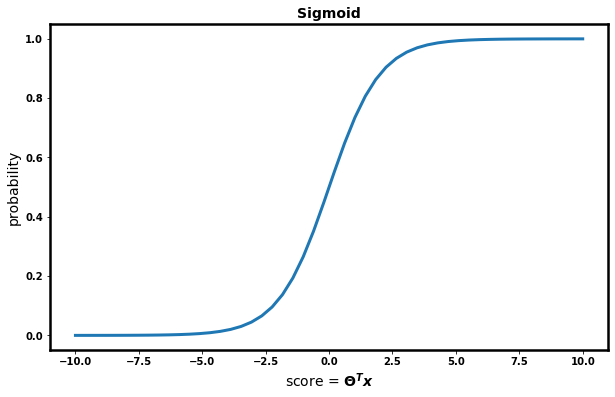

In [7]:
fig, ax = plt.subplots(figsize=(10,6))
_= lsh.plot_sigmoid(ax)

If we transform the probability into log odds, we make the targets linear in the features.

In [8]:
s = np.linspace(-10,10, 50)
sigma_s = 1/(1 + np.exp(- s))

p = sigma_s
eps = 1e-8

log_odds = np.log(p/(1 -p + eps))

fig, axs = plt.subplots(1,2, figsize=(12,6))

_= axs[0].plot(p)
_= axs[0].set_xlabel("score")
_= axs[0].set_ylabel("probability p")

_= axs[1].plot(log_odds)
_= axs[1].set_xlabel("score")
_= axs[1].set_ylabel("log odds")

fig.tight_layout()
plt.close(fig)

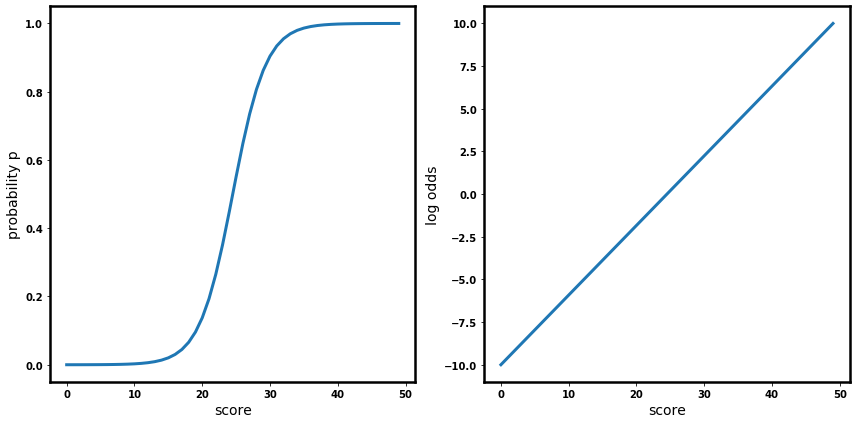

In [9]:
fig

<img src="images/Back_to_parent.jpg">

# Transformation to add a "missing" numeric feature

Sometimes our models can't fit the data because some key feature is missing.

This was the case for our "curvy" data and Linear model: the polynomial term was missing.

The model
$$ \y = \Theta_0 + \Theta_1 * \x_1$$
was not a good match for the data, but
$$ \y = \Theta_0 + \Theta_1 * \x_1 + \Theta_2* \x_1^2$$
was a much better fit.

Both models are linear, but the linearity of the relationship between target and features
did not become clear until the missing feature $\x_1^2$ was added.

An identical transformation works for a Classification task:


By adding polynomial features
- We achieve separability
- The separating boundary is linear in *transformed features*
- But clearly not linear in raw features

In [10]:
svmh = svm_helper.SVM_Helper()

_= svmh.create_kernel_data()

gamma=1
C=0.1

linear_kernel_svm = svm.SVC(kernel="linear", gamma=gamma)

# Pipelines
feature_map_poly2 = PolynomialFeatures(2)
poly2_approx = pipeline.Pipeline( [ ("feature map", feature_map_poly2),
                                    ("svm", svm.LinearSVC())                 
                                  ])

classifiers =  [ ("SVC", linear_kernel_svm),
                ("poly (d=2) transform + SVC", poly2_approx)
               ]
_= svmh.create_kernel_data(classifiers=classifiers)      
fig, axs = svmh.plot_kernel_vs_transform()
plt.close()

/home/kjp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


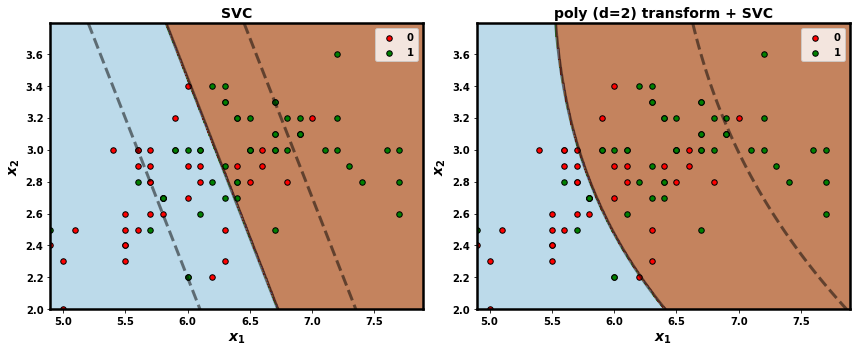

In [11]:
fig

- Left plot shows a boundary that is linear in raw features
- Right plot show a boundary that is linear in transformed features
    - plotted in the dimensions of raw features

The transformation results in a boundary shape with greater flexibility.

Here is another common transformation that adds a feature to facilitate linear separability.

Consider the follow examples
- Which, to the eye, are separable
- But are not linearly separable

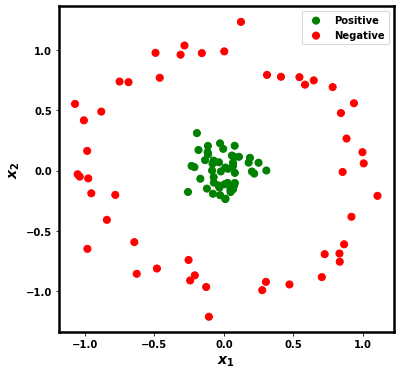

In [12]:
fig, ax = plt.subplots(1,1, figsize=(6,6) )
Xc, yc = svmh.make_circles(ax=ax, plot=True)

Visually, we can see that the classes are separable, but clearly not by a line.

Here's what one linear classifier (an SVC, which we will study later) produces

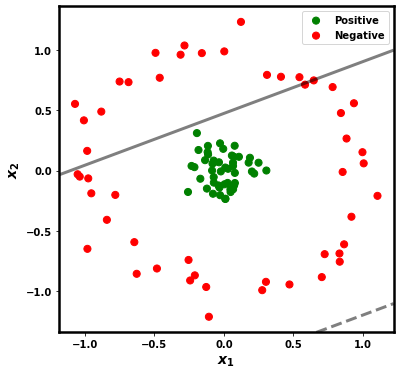

In [13]:
fig, ax = plt.subplots(1,1, figsize=(6,6) )
svm_clf = svmh.circles_linear(Xc, yc, ax=ax)

Let's add a new feature defined by the (Gaussian) *Radial Basis Function (RBF)*
$$
\x_3 = e^{ - \sum_j { \x_j^2 } }
$$

Our features are now 3 dimensional; let's look at the plot:

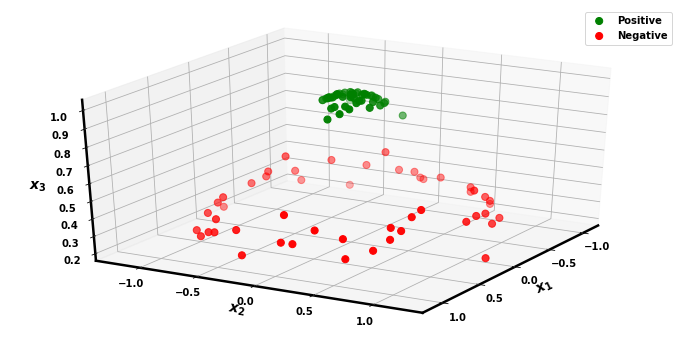

In [14]:
X_w_rbf = svmh.circles_rbf_transform(Xc)
_= svmh.plot_3D(X=X_w_rbf, y=yc )

Magic ! The new feature enables a plane that is parallel to the $\x_1, \x_2$ plane to separate the two classes.

We can write the RBF transformation in a more general form:
$$
\text{RBF}(\x) = e^{ - || \x - \x_c || }
$$

- $|| \x - \x_c ||$ is a measure of the distance between example $\x$ and reference point $\x_c$
- In our case
    - $|| \x - \x_c ||$ is the L2 (Euclidean) distance
    - $\x_c$ is the origin $(0, 0)$

There is an even simpler transformation we could have used.

$$ 
\x_3 = - \sum_j { \x_j^2 } 
$$

That is: the (negative) of the L2 distance.

The advantage of the RBF is that it has little effect on points far from the reference point.

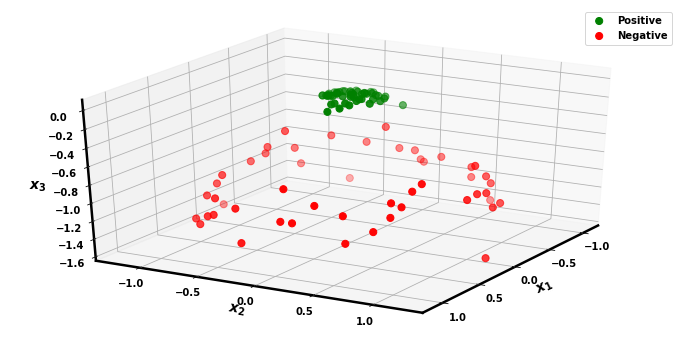

In [15]:
X_w_rad = svmh.circles_radius_transform(Xc)
_= svmh.plot_3D(X=X_w_rad, y=yc )

Although this transformation seems magical, we must be skeptical of magic
- There should be some *logical* justification for the added feature
- Without such logic: we are in danger of overfitting and will fail to generalize to test examples

For example:
- Perhaps $\x_1, \x_2$ are geographic coordinates (latitude/longitude)
- There is a distinction (different classes) based on distance from the city center $(\x_1, \x_2) = (0,0)$
    - e.g. Urban/Suburban


<img src="images/Back_to_parent.jpg">

# Transformation to add a "missing" categorical feature

Here is a less obvious case of a missing feature.

Suppose we obtain examples
- At different points in time
- Or in distinct geographies

What we often observe is that the examples
- From the same time/same place are similar to one another
- From different times/places are quite different

That is: the data naturally partitions into self-similar "groups".

How do we pool data that is similar intra-group but different across groups ?

Here is an artificial data set (Price  as a function of Size) sampled at two different dates.

We will refer to the data at each date as a "group".

In [16]:
sph = transform_helper.ShiftedPrice_Helper()
series_over_time = sph.gen_data()

fig, ax = plt.subplots(1,1, figsize=(12,6) )
_= sph.plot_data(series_over_time, ax=ax)

plt.close(fig)

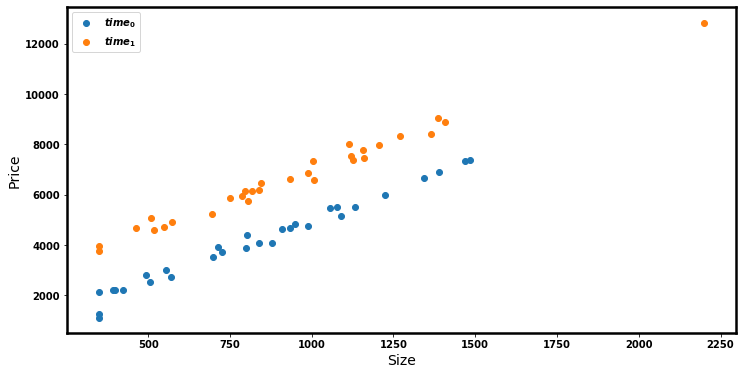

In [17]:
fig

It appears that
- The groups are defined by examples gathered at different times: $\text{time}_0, \text{time}_1$
- There is a linear relationship *in each group* in isolation
- There slope of the relationship is *the same* across time
- But the intercept differs across groups
    - Perhaps this reflects a tax or rebate that is independent of price.
    



Here's a set of equations that describes the data (separately for each of the two groups):
$$
\begin{array}[lll]\\
\y_{(\text{time}_0)} & = & \Theta_{(\text{time}_0)} + \Theta_1 * \x \\
\y_{(\text{time}_1)} & = & \Theta_{(\text{time}_1)} + \Theta_1 * \x \\
\end{array}
$$

Trying to fit a line (Linear Regression) as a function of the combined data will be disappointing.


Consider the transformation 
- That adds a *categorical feature* `time` with two discrete values
- Encoded via OHE as two binary *indicators* 

$$
\text{Is}_j^\ip = 
\left\{
    {
    \begin{array}{lll}
     1 & \textrm{if } \x^\ip  \text{ is in group } j  &  \\
     0 & \textrm{if } \x^\ip  \text{ is NOT in group } j  &  \\
    \end{array}
    }
\right.
$$

For example:
- if example $i$ is from the time 0 group
$$
\begin{array}[lll]\\
\text{Is}_0^\ip = 1 \\
\text{Is}_1^\ip = 0 \\
\end{array}
$$

Because $\text{Is}_0 $ and $\text{Is}_1$ are complementary 
- The following single equation combines the two groups without losing the distinction

$$
\begin{array}[lll]\\
\y & = & \Theta_{(\text{time}_0)} * \text{Is}_0 + \Theta_{(\text{time}_1)} * \text{Is}_1  + \Theta_1 * \x \\
\end{array}
$$

Effectively, the equation allows each group to have its own intercept !

This is equivalent to 
- Fitting one line per group, with the same slope
- But different intercepts

Here's what the design matrix $\X''$ looks like when we add the two indicators:

$
  \X'' = \begin{pmatrix}
  \mathbf{Is}_0 & \mathbf{Is}_1  & \mathbf{other \; features}\\
  1 & 0  & \ldots \\ 
   0 & 1  & \ldots\\ 
   \vdots \\
  \end{pmatrix}
  \begin{matrix}\\
  \text{time}_0 \\
  \text{time}_1 \\
  \\
  \end{matrix}
$

- Examples from the first time period look similar to the first row
- Examples from the second time period look similar to the second row


Notice that there is no "constant" feature in the design matrix
- Would correspond to the "intercept" term in linear regression

The reason for this is
- We already have **two** intercept-like terms $\text{Is}_0$ and $\text{Is}_1$
- The constant feature would be equal to the sum of these two features, for each example
    - Creates *dummy variable* trap for Linear Regression
    

There are many reasons that groups are formed, such as differences in
- Time that examples were sampled
- Geography
- Some other property with a constant impact

Adding the indicator allows the groups to share a common $\Theta_1$ (slope) but have
different $\Theta_0$ (intercepts).


<img src="images/Back_to_parent.jpg">

# Cross features

We have already seen a number of examples where adding a simple indicator succeeded in
making our data linearly separable.

Sometimes though, an indicator on a *single* feature won't suffice
- But a synthetic feature that is the *product* of indicators will
- Can indicate an example's presence in the *intersection* of two groups

A synthetic feature created by combining (multiplying) two or more simple features is called
a *cross term*

Let's revisit our circle classification dataset.

Here we create a cross feature that is `True` if two simpler features hold simultaneously
- $\x_1$ indicator: the horizontal offset from the origin $(0,0)$ is "small"
- $\x_2$ indicator: the vertical  offset from the origin $(0,0)$ is "small"

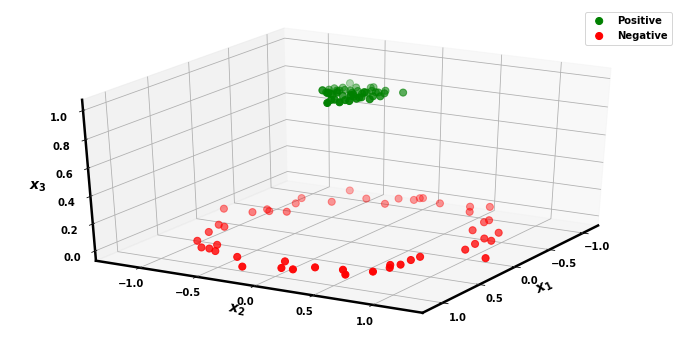

In [18]:
X_w_sq = svmh.circles_square_transform(Xc)
_= svmh.plot_3D(X=X_w_sq, y=yc )

Here's the code to create the new feature "r" as a cross term

We created a single "cross product" indicator $\text{Is}_{\text{in area}}$ as the product of two indicators, one per feature
    
$$
\begin{array}[lll]\\
\text{Is}_{\text{in } \x_1 \text{ range}} = (|\x_1| \le 0.5)\\
\text{Is}_{\text{in } \x_2 \text{ range}} = (|\x_2| \le 0.5)\\
\text{Is}_{\text{in area}} = \text{Is}_{\text{in $\x_1$ range}} * \text{Is}_{\text{in $\x_2$ range}} \\
\end{array}
$$

The *cross term* $\text{Is}_{\text{in area}}$ indicates being in the *intersection*
of $\text{Is}_{\text{in } \x_1 \text{ range}}$
and
$\text{Is}_{\text{in } \x_2 \text{ range}}$.

Note that only the single $\text{Is}_{\text{in area}}$ indicator is included in the equation
and design matrix $\X''$

The isolated indicators 
$$\text{Is}_{\text{in } \x_1 \text{ range}}, \text{Is}_{\text{in } \x_2 \text{ range}}$$
don't appear in the final regression equation -- they are used only to define $\text{Is}_{\text{in area}}$

Cross terms are very tempting but can be abused when over-used.

To illustrate potential for abuse, it is possible to
- Create *one indicator per example*
- Create a cross term of the example indicator with each parameter in $\Theta$
- This results in a completely separate set of parameters for *each* example
    - We "memorize" the data !

Here's a picture of the "per example" indicator

First, construct an indicator which is true
- if an example's feature $j$ value is equal to the feature $j$ value of example $i$:

$$
\text{Is}_{\x^\ip_j} = (\x_j = \x^\ip_j)
$$

Now construct a cross feature that combines the indicators for all $j$ and a single example $i$:
$$
\begin{array}[lll]\\
\text{Is}_{\text{example }i} & = & (\x_1 = \x_1^\ip) * (\x_2 = \x_2^\ip)\\
\end{array}
$$

This cross feature will be true on example $i$.

We can construct such a cross feature that recognizes any single example.

And here's the design matrix $\X''$ with a separate intercept per example.

$\X''$ has $m$ intercept columns, one for each example,
forming a diagonal of 1's

$
  \X'' = \begin{pmatrix}
  \mathbf{const} & \text{Is}_{\text{example 1}} & \text{Is}_{\text{example 2}} & \text{Is}_{\text{example 3}} & \ldots & \mathbf{other \; features}\\
  1 &  1 & 0  & 0 & \ldots \\ 
  1 &  0 & 1  & 0 & \ldots\\ 
  1 &  0 & 0  & 1 &\ldots\\ 
   \vdots \\
  \end{pmatrix}
$

We can do the same for $\Theta_1, \Theta_2, \ldots, \Theta_n$
resulting in a design matrix $\X''$ with $m * n$ indicators
- One per example per parameter


Here's a design matrix $\X''$ with one set of parameters per example:
\
$
  \X'' = \begin{pmatrix}
  \mathbf{const} & \text{Is}_{\text{example 1}} & (\text{Is}_{\text{example 1}} *\x_1) & (\text{Is}_{\text{example 1}} * \x_2) & \ldots & \text{Is}_{\text{example 2}} & (\text{Is}_{\text{example 2}} *\x_1) & (\text{Is}_{\text{example 2}} * \x_2) & \ldots\\
  1 &  1 & \x^{(1)}_1  & \x^{(1)}_2 & \ldots & 0 & 0 & 0\\ 
  1 &  0 & 0          & 0         & \ldots  &  1 & \x^{(2)}_1  & \x^{(2)}_2 \\  
   \vdots \\
  \end{pmatrix}
$

Using this as the design matrix in Linear Regression
- Will get a perfect fit to training examples
- Would likely **not generalize** well to out of sample test examples.

When truly justified a small number of complex cross terms are quite powerful.

<img src="images/Back_to_parent.jpg">

# Scaling

Sometimes it is necessary to restrict the *scale* of our data
- Features and targets

There are several reasons
- Some models are sensitive to scale
    - Features with large differences in scale may affect the model
- Some Loss  functions are sensitive to scale

## Some scalers

Scaling transformations are relatively simple mathematically.

Let's discuss the *how* of scaling before delving into the *why*.

**Note**
Scaling may be applied to a variable regardless of whether it is a feature of target.



### MinMax

Convert to $[0,1]$ range.

$$
\tilde{\x}^\ip_j = \frac{ \x^\ip_j -  \min{1 \le i \le m}(\x^\ip_j) }{ \min{1 \le i \le m}(\x^\ip_j) - \min{1 \le i \le m}(\x^\ip_j }
$$

New feature is measured in units of "fraction of range".

### Standardize

$$
\tilde{\x}^\ip_j = { { \x^\ip_j - \bar{\x_j} } \over { \sigma_{\x_j}} }
$$

The new feature has a mean of $0$, i.e., is *zero centered*.

New feature is measured in units of "number of standard deviations".


## Loss functions sensitive to scale

One reason for scaling features is the mathematics of the model.

Consider the behavior of the KNN Classification model
on a set of examples in which the two features $\x_1, \x_2$ are roughly the same scale.




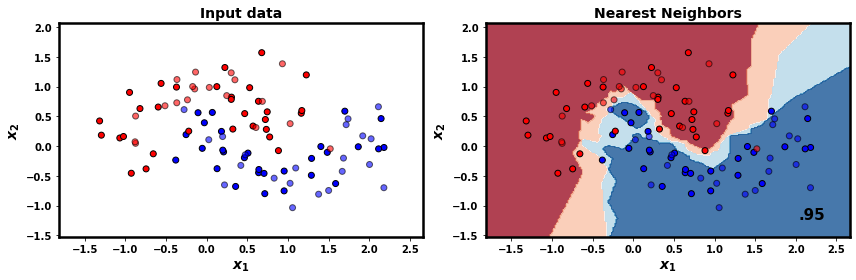

In [19]:
_=  kn.plot_classifiers(scale=False)

What would happen if the scales were very different for the two features ?

Let's "stretch" the first feature by multiplying it by a factor of 10, leaving the second feature unchanged.

(n.b., accuracy is the number in the lower right of the prediction plot)


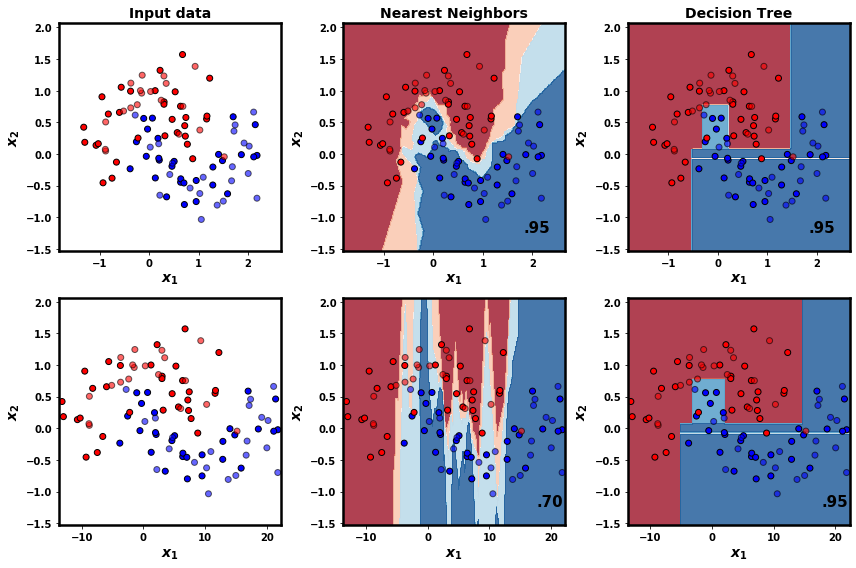

In [20]:
kn = tmh.KNN_Helper()

_ = kn.plot_classifiers(scale=False, num_ds=2)

The first row shows the original dataset; the second the "stretched" data set (i.e., scale of $\x_1$)

**Note** the horizontal scale of the lower plot is 10 times the upper.
- The plots look the same because the plotting routine keeps the plot sizes the same.

As you can see, the KNN classifier produces drastically different results on the two datasets.

Arguably KNN's predictions on the stretched dataset feel overfit.
- Even with overfitting: accuracy drops from 95% to 70%

What is the reason for this ?

If you recall our brief introduction to KNN: 
- The classifier measures the distance between features in a test example and feature in (each) training example
- The distance measure (L2, sum of squared feature-wise differences) is sensitive to scale

$$
\begin{array}[lll]\\
(\x^\ip_1, \x^\ip_2) & \text{training example } i \\
(10 * \x^\ip_1, \x^\ip_2) & \text{stretched training example } i \\
\\
(\x^{(test)}_1, \x^{(test)}_2) & \text{test example} \\
\end{array}
$$

$$
\begin{array}[lll]\\
(\x^{(test)}_1 - \x^\ip_1)^2 & + (\x^{(test)}_2 - \x^\ip_2)^2  & \text{distance from test}\\
(\x^{(test)}_1 -  10 *\x^\ip_1)^2 & + (\x^{(test)}_2 - \x^\ip_2)^2 &\text{stretched distance from test}
\end{array}
$$

Differences in $\x_1$ are much more important than differences in $\x_2$ in the stretched data.


The issue is that the distance metric used by KNN is *sensitive to feature scale*.

By rescaling both features to be on a similar scale (as in the raw input)
- We balance the contribution to distance from each feature
- Removing the sensitivity

Let's see how the KNN Classifier and
the Decision Tree classifier (topic of a subsequent lecture)
behave if we re-scale by Standardization

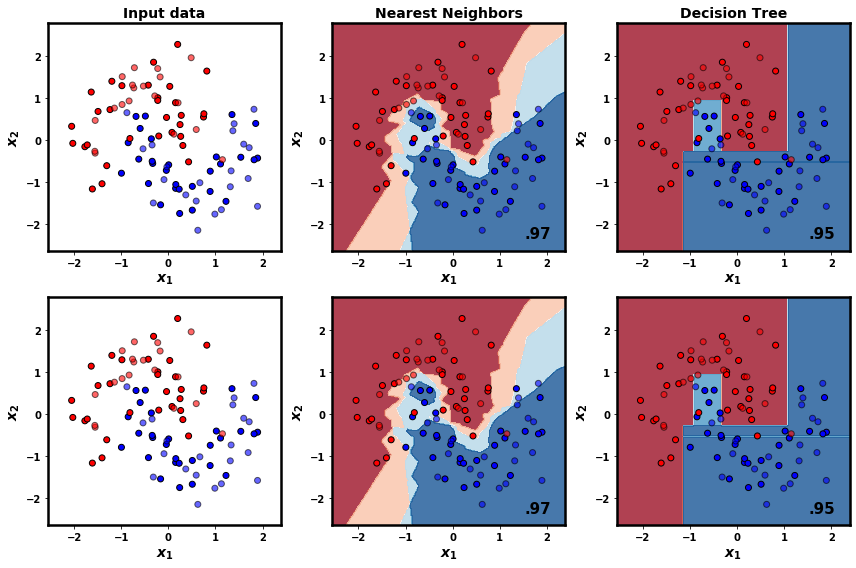

In [21]:
kn = tmh.KNN_Helper()

_ = kn.plot_classifiers(scale=True, num_ds=2)

- Both features now on *identical* scale (Input plot is now of Standardized features)
- The fit of the KNN Classifier is more sensible
    - And Accuracy improves relative to the raw, unscaled input
- The fit and Accuracy of the Decision Tree Classifier is unaffected

So
- The KNN model **is** sensitive to scale
- The Decision Tree model **is not** sensitive to scale.
In contrast, the Decision Tree classifier (which will be the topic of a subsequent lecture)


Differences in scale might inadvertently creep into the data.

- Millimeters rather than meters
- Whole dollars rather than cents (hundredths of a dollar)


**Bottom line**
- Know the math behind your model ! Don't blindly "use an API".

We will encounter scale sensitivity once more
- Upcoming lecture on Principal Components
- Results change when we use
    - The Correlation matrix (i.e., scaled data)
    - The Covariance matrix (i.e., unscaled data)


## Parameters sensitive to scale 



Consider the linear model
$$
\y = \Theta_1 * \x_1
$$

If we inflate $\x_1$ by a factor of 10
then $\Theta_1$ will mathematically need to decrease by the same factor
$$
\begin{array}[ll]\\
\y  & = & \frac{\Theta_1}{10} * ( 10 * \x_1) \\
    & = & \Theta'_1 * \x'_1
\end{array}
$$

Changing the scale of the feature *also* changes the scale of the corresponding parameter.

Why might this matter ?

Again: there are Loss functions where the scale of **parameters** (rather than features) matter.

## Loss functions sensitive to scale: regularization penalty

When a model has too many parameters (always count them!)
- Many elements of the $\Theta$ vector may be near 0

Recall too the symptom of the Dummy Variable trap
- Pairs of parameters with similar absolute magnitude but opposite sign


*Regularization* is a technique
- That modifies the Loss function
- By adding a *penalty*
- With the effect of encouraging small, near zero parameter values

That is, the Loss function becomes a *Regularized Loss*
$$\loss + (\alpha * Q)$$
where 
- $Q$ is a penalty that is a function of $\Theta$
- $\alpha$ is the *strength* of the penalty
- $\loss$ is the unregularized Loss function

(See our Deep Dive notebook section [Regularization](Bias_and_Variance.ipynb#Regularization:-reducing-overfitting) for more detail.

Because scaling a feature may rescale the *corresponding parameter*
- The penalty $Q$ will be affected
- And so too the regularized Loss

[Ridge Regression](external/PythonDataScienceHandbook/notebooks/05.06-Linear-Regression.ipynb#Ridge-regression-%28$L_2$-Regularization%29)
is basically Linear Regression with a penalty that is the sum of squared parameters values

​
$$
Q = \sum_{n=1}^N \Theta_n^2
$$

In our example
- Inflating the sole parameter $\x_1$ by a factor of 10
- Decreases the corresponding parameter $\Theta_1$ by a factor of 10
- Decreases the corresponding penalty by a factor of 100

Note that even something as "benign" as changing units from meters to millimeters has a big effect.


[Lasso Regression](external/PythonDataScienceHandbook/notebooks/05.06-Linear-Regression.ipynb#Lasso-regression-%28$L_1$-regularization%29)
is Linear Regression with a penalty that is the sum of the absolute value of parameters

$$
Q = \alpha\sum_{n=1}^N |\Theta_n|
$$

In our example
- Inflating the sole $\x_1$ parameter by a factor of 10
- Decreases the corresponding parameter $\Theta_1$ by a factor of 10
- Decreases the corresponding penalty by a factor of 10


It is easy to forget (and get burned !) by the Scaling transformation
when you innocently add a Regularization penalty to the loss.

## Feature scaling: summary

- A very simple operation
- With subtle but significant impact

Preview:
- In the Deep Learning part of the course
- We will see the need to scale features
    - Small magnitude


<img src="images/Back_to_parent.jpg">

# Normalization

This illustration is somewhat similar to the one used for Missing Categorical feature.

Again, suppose our examples form natural sub-groups.
- Unlike the first example: there is a *different slope* in each sub-group
- But this may be solely a result of using **different units of measurement** for the same feature in different sub-groups


Here is an artificial data set
relating Price to Size.
- Where Price is measured in *local currency* in different countries


In [22]:
rph = transform_helper.RelativePrice_Helper()
series = rph.gen_data(attrs=["area", "price"])

labels=[ "USD", "USD", "RMB", "HKD" ]

fig, ax = plt.subplots(1,1, figsize=(12,6))
_= rph.plot_data(series, ax=ax, labels=labels, xlabel="Area", ylabel="Price (local)")

plt.close(fig)

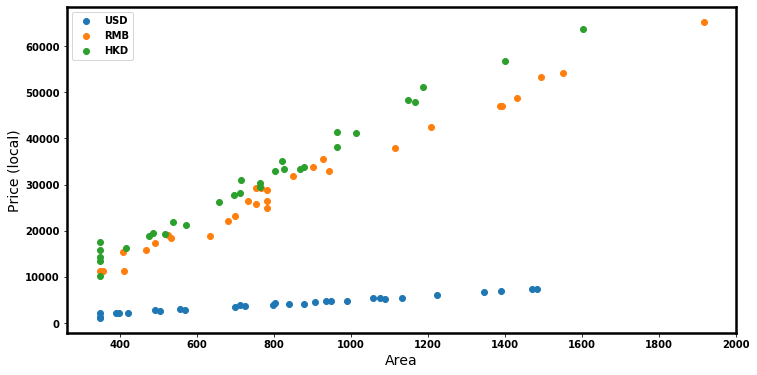

In [23]:
fig

The examples of each sub-group are colored differently.

There is clearly a linear relationship intra-group, but the slope differs between groups (local currencies).

The apparent diversity in the target may obscure a simple relationship
- The relationship is the **same** when 
- The target within a group $g$: $\y^\ip_{(\text{group}_g)}$
- Is re-denominated in a single currency $\tilde{\y}^\ip_{(\text{group}_g)} = \frac{\y^\ip_{(\text{group}_g)}}{ \beta_{(\text{group}_1)}}$

In [24]:
# Relative price levels
rel_price = rph.relative_price()

# Normalize the price of each series by the relative price        
series_normalized = [ series[i]/(1,rel_price[i]) for i in range(len(series))]

fig, ax = plt.subplots(1,1, figsize=(12,6))
_= rph.plot_data(series_normalized, ax=ax, labels=labels, xlabel="Area", ylabel="Price (USD)")

plt.close(fig)

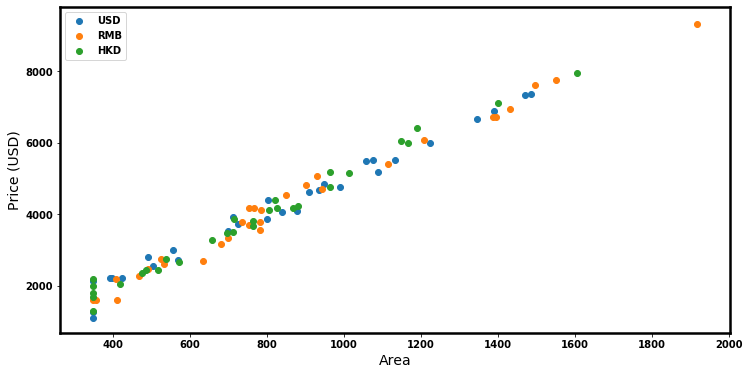

In [25]:
fig

Here's an equation that describes the data for the first two sub-groups:

$$\
\begin{array}[lll]\\
\y_{(\text{group}_0)} & = &  \beta_{(\text{group}_0)}  *( \Theta_0 + \Theta_1 * \x ) \\
\y_{(\text{group}_1)} & = &  \beta_{(\text{group}_1)}  *( \Theta_0 + \Theta_1 * \x ) \\
\end{array}
$$

And the regression equation for the transformed data:
$$
\begin{array}[lll]\\
\frac{\y_{(\text{group}_0)}}{ \beta_{(\text{group}_0)}} & = &   \Theta_0 + \Theta_1 * \x  \\
\frac{\y_{(\text{group}_1)}}{ \beta_{(\text{group}_1)}} & = &   \Theta_0 + \Theta_1 * \x  \\
\end{array}
$$

The phenomenon of variables denominated in different units between sub-groups is not uncommon
- Examples observed in different countries, measured in local currency
- Examples observed at different times (e.g., adjust for time-varying general price level)

In our case, the only variable that needed to be normalized was the target.

You can imagine situations in which features (e.g., Area) need to be normalized
- Meters versus feet

There is often no "best" currency/commodity in which to re-denominate Price level
- Consider re-denominating so that "pricing power" is constant
    - Units of "number of McDonald's burgers" !
    - May work across time and currency !

As long as all commodity prices change the same, this should work.

# Categorical transformation

We encountered the "to categorical" transformation in the lecture on Classification when
talking about Categorical variables.

The recommended solution was to use One Hot Encoding for Categorical variables.


<img src="images/Back_to_parent.jpg">

# Normality inducing transformations

## Adding missing feature as a normality inducing transformation


The Linear Regression model is
$$
\y = \Theta^T \x + \epsilon
$$

As explained before, Regression produces a conditional probability
$$
\pr{\hat{\y} | \x}
$$

where $\hat{\y}$ and $\epsilon$ are *Normally distributed variables*.

Assumptions of the Linear Regression model are violated if
- $\epsilon$ is not Normal
- the individual $\epsilon^\ip$ display a pattern
- the individual $\epsilon^\ip$ have different variances (heteroscedastic)


One reason for failure of these assumptions is a missing feature
- "curvy" data set and Linear model
    - we saw pattern of errors: larger in tails
    - variances increased in tail

Adding a feature (e.g.,second order polynomial term for the curvy data set) can be seen
as a normality inducing transformation.

## Log transformation

We've seen this in our lecture on Logistic Regression
- the probabilities are *not* normally distributed
- the odds are *not* normally distributed
- the *log odds* **is** normally distributed


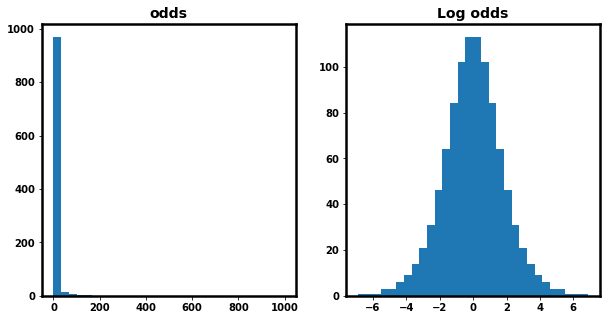

In [26]:
tf = tmh.TransformHelper()
tf.plot_odds()

$$
\begin{array}{llll}
\hat{p} \over {1- \hat{p}} & = &  { 1 \over { 1 + e^{-s} } } \over { 1 -  {1 \over { 1 + e^{-s} } } } \\
& = & { 1 \over { 1 + e^{-s} } } \over { {1 + e^{-s}  -1} \over {1 + e^{-s}} } \\
& = & 1 \over {e^{-s}} \\
& = & e^{s}
\end{array}
$$



So `LogisticRegression` is really just a `LinearRegression` with a transformed target

$$
\textrm{log}( {\hat{p} \over {1- \hat{p}}}) = \Theta^T \cdot x
$$

# Other transformations

## Centering

Transforming a feature to have mean $0$.

$$
\x^\ip_j = \x^\ip_j - \bar{\x}_j
$$

- low values now become negative
    - more clearly indicates deleterious effect than a low, positive number
    - example: Star Ratings for movies
- some algorithms (PCA) need centered data


## Bucketing/Binning

- Target may be linear in a feature only in broad ranges of the feature
    - income vs age
        - very young (below working age) all income is identical (0)
        - very old (above retirement) - no job related income
    - Latitude/Longitude
        - small changes matter MUCH less than big changes
        
- Converts numerical feature 
    - into categorical $\mathbf{Is \; bucket \; 1}, \mathbf{Is \; bucket \; 2}, \ldots$
    - ordinal: replace value with center value of bin

Bucket size choices:
- Equal spaced buckets
- Equal quantile buckets

**Lesson** Don't fit a square peg (non-linear response) into a round hole (linear model)

## Outliers

Pull in extreme values to reduce their influence on the fit.

- Clipping, Winsorization

# Feature engineering example: Geron Housing Data
[Geron housing data](external/handson-ml/02_end_to_end_machine_learning_project.ipynb#Get-the-data)
 

## Data: California Housing Prices Data (AG Chapt 2)

In [27]:
housing = tm.load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Each row represents a district

Goal is to predict Median House Value in the district.

- Features
    - total_rooms: number of rooms in the district
    - total_bedrooms: number of bedrooms in the district
    - households; number of households in the district
    - population: number of people in the district
    - median_income: median income of people in the district
    - 
- Target
    - median_house_value: median value of a house in the district

What potential issues pop out ?

Some *raw* features depend on the *size* of the district, so can't compare the same feature across districts.

- total_rooms, total_bedrooms, households, population 

### Feature engineering: Normalization

The first transformation is a kind of normalization
- adjusting a feature for the size of the district
    - divide district aggregate by number of items in the district
- makes the feature comparable across districts of different sizes

In [28]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

By synthesizing ratios:
- rooms/household
- population/household
- bedrooms/room

we have transformed the raw features into processed features that will probably be better predictors

### Feature engineering: Bucketing and Clipping

- Will $1 more of income *really* predict higher housing prices in the district ?
    - create income buckets
        - Disclaimer
            - In the book this is **not** a feature but something used to "stratify" the sample
            - We are taking a bit of artistic license to make a point

In [29]:
print("Median income ranges from {min:.1f} to {max:.1f}".format(min=housing["median_income"].min(), 
                                                                max=housing["median_income"].max()
                                                               ))
# Divide by 1.5 to limit the number of income categories
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)

print("Income buckets")
housing["income_cat"].value_counts()

Median income ranges from 0.5 to 15.0
Income buckets


3.0     7236
2.0     6581
4.0     3639
5.0     1423
1.0      822
6.0      532
7.0      189
8.0      105
9.0       50
11.0      49
10.0      14
Name: income_cat, dtype: int64

Still a lot of buckets.  One theory is that incomes above bucket 5 don't predict housing prices, so clip.

In [30]:
# Label those above 5 as 5
housing["income_cat_clipped"] = housing["income_cat"].where(housing["income_cat"] < 5, 5.0)
print("Income buckets")
housing["income_cat_clipped"].value_counts()

Income buckets


3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat_clipped, dtype: int64

In [31]:
print("Done")

Done
